In [1]:
# %%
# =============================================================================
# Passo 1: Importação de Bibliotecas
# =============================================================================

# Bibliotecas padrão
import csv
import gc
from pathlib import Path

# Bibliotecas de terceiros para análise e manipulação de dados
import numpy as np
import pandas as pd
import openpyxl
from scipy.stats import skew, kurtosis, ttest_ind

# Bibliotecas para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Ferramentas de pré-processamento do Scikit-learn
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

In [2]:
# %%
# =============================================================================
# Passo 2: Carregamento e Concatenação dos Dados
# =============================================================================

# --- Funções de Leitura Robusta (sem alteração) ---
def detectar_delimitador(caminho_arquivo: Path, tamanho_amostra: int = 65536) -> str:
    with caminho_arquivo.open("rb") as f:
        amostra = f.read(tamanho_amostra)
    for enc in ("utf-8", "latin-1", "cp1252"):
        try:
            texto = amostra.decode(enc, errors="strict")
            dialect = csv.Sniffer().sniff(texto, delimiters=";,")
            return dialect.delimiter
        except Exception:
            continue
    return ";"

def ler_csv_robusto(caminho_arquivo: Path) -> pd.DataFrame:
    sep_detectado = detectar_delimitador(caminho_arquivo)
    encodings = ("utf-8-sig", "utf-8", "latin-1", "cp1252")
    erros = []
    for enc in encodings:
        try:
            # Usar low_memory=False para evitar inferência de tipo por chuncks, prevenindo erros
            return pd.read_csv(caminho_arquivo, sep=sep_detectado, encoding=enc, low_memory=False, engine="c")
        except Exception as e:
            erros.append((f"engine=c | {enc}", str(e)))
    
    # Fallback para engine python se o 'c' falhar
    for enc in encodings:
        try:
            return pd.read_csv(caminho_arquivo, sep=sep_detectado, encoding=enc, engine="python", on_bad_lines="skip")
        except Exception as e:
            erros.append((f"engine=python | {enc}", str(e)))
            
    msg = f"Falha ao ler {caminho_arquivo.name}. Erros:\\n" + "\\n".join([f" - {ctx}: {err}" for ctx, err in erros])
    raise RuntimeError(msg)



In [3]:
# --- Processo de Leitura e Concatenação ---

# Caminho para a pasta com os arquivos CSV
pasta_csvs = Path.cwd() / "Bases" / "0_RAIS_Bases_Amostra" / "RAIS_Enap_amostra_"
assert pasta_csvs.exists(), f"Pasta não encontrada: {pasta_csvs}"

# Listar e ler os arquivos
arquivos_csv = sorted([p for p in pasta_csvs.glob("*.csv")])
if not arquivos_csv:
    raise FileNotFoundError("Nenhum CSV encontrado na pasta indicada.")

print(f"Arquivos encontrados: {len(arquivos_csv)}")
dataframes = []
for idx, arq in enumerate(arquivos_csv, start=1):
    print(f"[{idx}/{len(arquivos_csv)}] Lendo: {arq.name} ...", end="")
    df_tmp = ler_csv_robusto(arq)
    dataframes.append(df_tmp)
    print(f" ok ({df_tmp.shape[0]} linhas, {df_tmp.shape[1]} colunas)")

# Concatena todos os DataFrames em um só
print("\\nConcatenando DataFrames...")
df = pd.concat(dataframes, ignore_index=True)
print("Dimensão final:", df.shape)



Arquivos encontrados: 11
[1/11] Lendo: RAIS_2014_Enap_amostra.csv ... ok (1128887 linhas, 37 colunas)
[2/11] Lendo: RAIS_2015_Enap_amostra.csv ... ok (1090572 linhas, 37 colunas)
[3/11] Lendo: RAIS_2016_Enap_amostra.csv ... ok (726162 linhas, 37 colunas)
[4/11] Lendo: RAIS_2017_Enap_amostra.csv ... ok (1073850 linhas, 37 colunas)
[5/11] Lendo: RAIS_2018_Enap_amostra.csv ... ok (1082710 linhas, 37 colunas)
[6/11] Lendo: RAIS_2019_Enap_amostra.csv ... ok (796532 linhas, 37 colunas)
[7/11] Lendo: RAIS_2020_Enap_amostra.csv ... ok (1109627 linhas, 37 colunas)
[8/11] Lendo: RAIS_2021_Enap_amostra.csv ... ok (1199769 linhas, 37 colunas)
[9/11] Lendo: RAIS_2022_Enap_amostra.csv ... ok (1245516 linhas, 37 colunas)
[10/11] Lendo: RAIS_2023_Enap_amostra.csv ... ok (1328596 linhas, 37 colunas)
[11/11] Lendo: RAIS_2024_Enap_amostra.csv ... ok (985182 linhas, 37 colunas)
\nConcatenando DataFrames...
Dimensão final: (11767403, 37)


In [4]:
# --- Otimização de Memória ---
# Remove a lista de dataframes e o dataframe temporário da memória
del dataframes
del df_tmp
gc.collect() # Executa o garbage collector para liberar memória
print("Memória liberada.")


Memória liberada.


In [5]:
# %%
# =============================================================================
# Passo 3: Limpeza, Filtragem e Transformação dos Dados (Versão Corrigida)
# =============================================================================

# --- 3.1: Remoção de Colunas Desnecessárias ---
colunas_para_remover = [
    "VinculoAtivo", "NRMesDesligamento", "TPAdmissao", "TPEstabelecimento", 
    "TPDeficiencia", "CDCausaAfastamento1", "CDCausaAfastamento2", "CDCausaAfastamento3", 
    "INTrabIntermitente", "VLRemunDezembroNom", "VLRemunDezembroSM", "VLSalarioContratual",
    "NRCNPJCEI", "NRCNPJRaiz", "CDCNAE20Subclasse"
]
existentes = [c for c in colunas_para_remover if c in df.columns]
df.drop(columns=existentes, inplace=True)
gc.collect()
print(f"Colunas removidas: {len(existentes)}. Shape após remoção: {df.shape}")


Colunas removidas: 15. Shape após remoção: (11767403, 22)


In [6]:
# --- 3.2: Conversão de Tipos de Dados ---
print("Convertendo tipos de dados...")
colunas_categoricas = [
    "CDDesligamento", "CDGrauEscolaridade", "CDNaturezaJuridica", "CDRacaCor", 
    "CDSexo", "CDTamanhoEstabelecimento", "INPortadorDefic", "INTrabParcial", 
    "TPVinculo", "CDCNAE20Classe", "CDMunicipio"
]
for col in colunas_categoricas:
    if col in df.columns:
        df[col] = df[col].astype("category")

if "DTAdmissaoDeclarada" in df.columns:
    df["DTAdmissaoDeclarada"] = pd.to_datetime(df["DTAdmissaoDeclarada"], errors='coerce', dayfirst=True)

# CORREÇÃO: Força a coluna CBO para string ANTES de qualquer outra operação
# Isso evita o erro de conversão para int no momento de salvar o Parquet.
if 'CDCBOOcupacao2002' in df.columns:
    df['CDCBOOcupacao2002'] = df['CDCBOOcupacao2002'].astype(str)

Convertendo tipos de dados...


In [7]:
# --- 3.3: Limpeza de Salários (Outliers) ---
print("Limpando outliers de remuneração...")
df.dropna(subset=["VLRemunMediaNom"], inplace=True)
df = df[(df["VLRemunMediaSM"] >= 0.3) & (df["VLRemunMediaSM"] <= 150)]
print(f"Shape após limpeza de salários: {df.shape}")


Limpando outliers de remuneração...
Shape após limpeza de salários: (11357549, 22)


In [8]:
# --- 3.4: Criação de Novas Colunas (Features) ---
print("Criando novas colunas...")
df['log_VLRemunMediaNom'] = np.log1p(df['VLRemunMediaNom'])

ocupacoes_map = {
    '0': 'FORÇAS ARMADAS, POLICIAIS E BOMBEIROS', '1': 'DIRIGENTES E GERENTES',
    '2': 'CIÊNCIAS E ARTES', '3': 'TÉCNICOS DE NÍVEL MÉDIO', '4': 'SERVIÇOS ADMINISTRATIVOS',
    '5': 'SERVIÇOS E VENDEDORES', '6': 'AGROPECUÁRIOS E PESCA', '7': 'PRODUÇÃO INDUSTRIAL (1)',
    '8': 'PRODUÇÃO INDUSTRIAL (2)', '9': 'REPARAÇÃO E MANUTENÇÃO'
}
df['GrupoOcupacao'] = df['CDCBOOcupacao2002'].str[0].map(ocupacoes_map).astype("category")


Criando novas colunas...


In [9]:
# --- 3.5: Filtragem por Capitais ---
print("Filtrando registros apenas das capitais...")
codigos_capitais = [
    431490, 330455, 520870, 355030, 250750, 261160, 221100, 292740, 510340, 150140, 
    410690, 270430, 230440, 240810, 280030, 110020, 120040, 130260, 500270, 310620, 
    421660, 172100, 160060, 211130, 320530, 530010
]
df['CDMunicipio'] = df['CDMunicipio'].astype('int64')
df = df[df['CDMunicipio'].isin(codigos_capitais)].copy()
gc.collect()
print(f"Pré-processamento concluído. Shape final do DataFrame de análise: {df.shape}")


Filtrando registros apenas das capitais...
Pré-processamento concluído. Shape final do DataFrame de análise: (4257681, 24)


In [10]:
# %%
# =============================================================================
# Passo 4: Salvamento do DataFrame Processado
# =============================================================================
saida_parquet = pasta_csvs / "RAIS_CAPITAIS_PROCESSADO.parquet"
df.to_parquet(saida_parquet, index=False, engine="pyarrow", compression="snappy")

print(f"DataFrame final salvo com sucesso em: {saida_parquet}")

DataFrame final salvo com sucesso em: C:\Users\Guilherme\OneDrive\Cursos\ENAP\MBA em Inteligência Artificial\Disciplinas\18 - Lab 02\Bases\0_RAIS_Bases_Amostra\RAIS_Enap_amostra_\RAIS_CAPITAIS_PROCESSADO.parquet


In [11]:
# %%
# =============================================================================
# Passo 5: Análise Exploratória e Testes de Hipóteses
# =============================================================================

# Configurações de exibição do Pandas
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

# Verificação inicial dos dados
print("Tipos de dados do DataFrame final:")
display(df.info())

print("\\nVisualização das primeiras linhas:")
display(df.head())

Tipos de dados do DataFrame final:
<class 'pandas.core.frame.DataFrame'>
Index: 4257681 entries, 1 to 11767401
Data columns (total 24 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   NRANO                     int64         
 1   CDMunicipio               int64         
 2   TPVinculo                 category      
 3   CDDesligamento            category      
 4   TPSalario                 float64       
 5   CDGrauEscolaridade        category      
 6   CDSexo                    category      
 7   CDRacaCor                 category      
 8   INPortadorDefic           category      
 9   CDTamanhoEstabelecimento  category      
 10  CDNaturezaJuridica        category      
 11  DTAdmissaoDeclarada       datetime64[ns]
 12  VLRemunMediaNom           float64       
 13  VLRemunMediaSM            float64       
 14  NRTempoEmprego            float64       
 15  NRQtdHoraContr            float64       
 16  CDCBOOcupacao2002      

None

\nVisualização das primeiras linhas:


,NRANO,CDMunicipio,TPVinculo,CDDesligamento,TPSalario,CDGrauEscolaridade,CDSexo,CDRacaCor,INPortadorDefic,CDTamanhoEstabelecimento,CDNaturezaJuridica,DTAdmissaoDeclarada,VLRemunMediaNom,VLRemunMediaSM,NRTempoEmprego,NRQtdHoraContr,CDCBOOcupacao2002,CDCNAE20Classe,NRIdade,INTrabParcial,Estoque_Total,Estoque_Fem,log_VLRemunMediaNom,GrupoOcupacao
1,2014,530010,30,0.0,1.0,9.0,2.0,99.0,0.0,10.0,1040.0,2005-04-03,23283.31,32.15,117.8,40.0,111405,84116.0,38.0,0.0,6135.0,2523.0,10.055535,DIRIGENTES E GERENTES
8,2014,130260,10,0.0,1.0,7.0,1.0,8.0,0.0,8.0,2062.0,NaT,749.30,1.03,22.3,44.0,412205,53202.0,27.0,0.0,345.0,252.0,6.620473,SERVIÇOS ADMINISTRATIVOS
9,2014,211130,10,0.0,1.0,7.0,1.0,8.0,1.0,8.0,2062.0,NaT,1082.88,1.49,15.3,44.0,784205,10929.0,37.0,0.0,433.0,181.0,6.988302,PRODUÇÃO INDUSTRIAL (1)
18,2014,355030,10,0.0,1.0,9.0,2.0,2.0,0.0,9.0,1112.0,NaT,11864.12,16.38,378.1,40.0,239410,85325.0,49.0,0.0,516.0,273.0,9.381358,CIÊNCIAS E ARTES
23,2014,250750,10,0.0,1.0,9.0,1.0,2.0,0.0,7.0,2062.0,1991-01-03,10047.07,13.87,285.9,44.0,142305,60217.0,72.0,0.0,216.0,75.0,9.215136,DIRIGENTES E GERENTES


Resumo estatístico:
count    4257681.00
mean        4430.63
std         6556.31
min          217.20
1%           581.16
5%           914.00
25%         1460.60
50%         2222.44
75%         4463.25
95%        15583.52
99%        32883.11
max       209000.00
Name: VLRemunMediaNom, dtype: float64

Assimetria (skew): 5.939  |  Curtose (kurtosis): 69.292
Zeros absolutos: 0


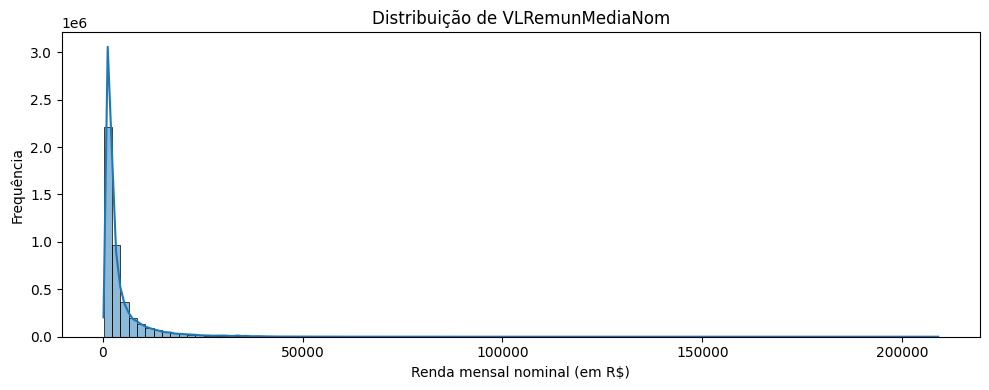

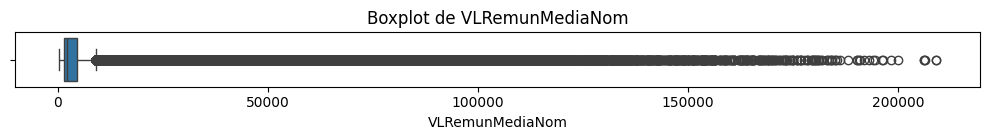

In [12]:
# %% Análise univariada da variável VLRemunMediaNom (já filtrada)

col = "VLRemunMediaNom"
s = pd.to_numeric(df[col], errors="coerce").dropna()

print("Resumo estatístico:")
print(s.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).round(2))
print(f"\nAssimetria (skew): {s.skew():.3f}  |  Curtose (kurtosis): {s.kurt():.3f}")
print(f"Zeros absolutos: {(s==0).sum()}")

# Histograma
plt.figure(figsize=(10,4))
sns.histplot(s, bins=100, kde=True)
plt.title("Distribuição de VLRemunMediaNom")
plt.xlabel("Renda mensal nominal (em R$)")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(10,1.5))
sns.boxplot(x=s)
plt.title("Boxplot de VLRemunMediaNom")
plt.tight_layout()
plt.show()


In [13]:
df_norm['log_VLRemunMediaNom'] = np.log1p(df_norm['VLRemunMediaNom'])


NameError: name 'df_norm' is not defined

In [ ]:
scaler_robust = RobustScaler()
df_norm['robust_VLRemunMediaNom'] = scaler_robust.fit_transform(df[['VLRemunMediaNom']])


In [ ]:
scaler_std = StandardScaler()
df_norm['std_VLRemunMediaNom'] = scaler_std.fit_transform(df[['VLRemunMediaNom']])


In [ ]:
scaler_minmax = MinMaxScaler()
df_norm['minmax_VLRemunMediaNom'] = scaler_minmax.fit_transform(df[['VLRemunMediaNom']])


In [ ]:


fig, axs = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(df_norm['log_VLRemunMediaNom'], ax=axs[0,0], kde=True).set(title='Log1p')
sns.histplot(df_norm['robust_VLRemunMediaNom'], ax=axs[0,1], kde=True).set(title='RobustScaler')
sns.histplot(df_norm['std_VLRemunMediaNom'], ax=axs[1,0], kde=True).set(title='StandardScaler')
sns.histplot(df_norm['minmax_VLRemunMediaNom'], ax=axs[1,1], kde=True).set(title='MinMaxScaler')
plt.tight_layout()
plt.show()


In [ ]:


# Adiciona nova transformação com PowerTransformer (Yeo-Johnson)
scaler_yeoj = PowerTransformer(method='yeo-johnson')
df_norm['yeoj_VLRemunMediaNom'] = scaler_yeoj.fit_transform(df_norm[['VLRemunMediaNom']])

# Avaliação estatística: skew e kurtosis
print("📊 Skew e Curtose das transformações:")
for col in [
    'VLRemunMediaNom',
    'log_VLRemunMediaNom',
    'robust_VLRemunMediaNom',
    'std_VLRemunMediaNom',
    'minmax_VLRemunMediaNom',
    'yeoj_VLRemunMediaNom'
]:
    s = skew(df_norm[col])
    k = kurtosis(df_norm[col])
    print(f"{col:<30} | Skew: {s:>7.3f} | Kurtosis: {k:>7.3f}")


In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

sns.histplot(df_norm['log_VLRemunMediaNom'], ax=axs[0,0], kde=True).set(title='Log1p')
sns.histplot(df_norm['robust_VLRemunMediaNom'], ax=axs[0,1], kde=True).set(title='RobustScaler')
sns.histplot(df_norm['std_VLRemunMediaNom'], ax=axs[0,2], kde=True).set(title='StandardScaler')

sns.histplot(df_norm['minmax_VLRemunMediaNom'], ax=axs[1,0], kde=True).set(title='MinMaxScaler')
sns.histplot(df_norm['yeoj_VLRemunMediaNom'], ax=axs[1,1], kde=True).set(title='PowerTransformer (Yeo-Johnson)')
sns.histplot(df_norm['VLRemunMediaNom'], ax=axs[1,2], kde=True).set(title='Original')

plt.tight_layout()
plt.show()


In [ ]:
# Aplicar o filtro para TPVinculo
codigos_validos = [10, 15, 20, 25, 35, 40, 60, 65, 70, 75, 80]
df_filtrado = df[df['TPVinculo'].isin(codigos_validos)].copy()

# Criar nova coluna com a renda normalizada via transformação logarítmica (log1p)
df_filtrado['log_VLRemunMediaNom'] = np.log1p(df_filtrado['VLRemunMediaNom'])


In [ ]:

plt.figure(figsize=(10, 5))
sns.histplot(df_filtrado['log_VLRemunMediaNom'], bins=100, kde=True)
plt.title('Distribuição log1p de VLRemunMediaNom (após filtro de TPVinculo)')
plt.xlabel('log_VLRemunMediaNom')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()


In [ ]:
df_filtrado.to_parquet("df_filtrado_log_VLRemunMediaNom.parquet", index=False)


In [ ]:

# Reimportar o DataFrame a partir do arquivo Parquet
df_filtrado = pd.read_parquet("df_filtrado_log_VLRemunMediaNom.parquet")

# Verificar as primeiras linhas
df_filtrado.head()


# Teste de hipóteses

In [ ]:
# Total antes do filtro
total_antes = len(df_filtrado)

# Proporção de valores nulos no campo de carga horária
prop_nulos = df_filtrado['NRQtdHoraContr'].isna().mean()
print(f'Proporção de valores nulos em NRQtdHoraContr: {prop_nulos:.2%}')

# Remoção de nulos
df_horas = df_filtrado.dropna(subset=['NRQtdHoraContr', 'CDSexo'])

# Total após o filtro
total_depois = len(df_horas)

print(f'Total de registros antes do filtro: {total_antes:,}')
print(f'Total de registros após o filtro:  {total_depois:,}')
print(f'Total removido: {total_antes - total_depois:,}')


In [ ]:
df_horas['CDSexo'] = df_horas['CDSexo'].map({1: 'Masculino', 2: 'Feminino'})


In [ ]:
df_horas.groupby('CDSexo')['NRQtdHoraContr'].describe()


In [ ]:

plt.figure(figsize=(8,5))
sns.boxplot(x='CDSexo', y='NRQtdHoraContr', data=df_horas)
plt.title("Distribuição da Carga Horária Contratada por Sexo")
plt.ylabel("Horas contratadas por semana")
plt.xlabel("Sexo")
plt.show()


In [ ]:


# Separação por sexo
homens = df_horas[df_horas['CDSexo'] == 'Masculino']['NRQtdHoraContr']
mulheres = df_horas[df_horas['CDSexo'] == 'Feminino']['NRQtdHoraContr']

# Teste de diferença de médias
t_stat, p_valor = ttest_ind(homens, mulheres, equal_var=False)


print(f"Estatística t = {t_stat:.3f}")
print(f"p-valor = {p_valor:.4f}")


In [ ]:
sns.kdeplot(data=homens, label="Masculino", fill=True)
sns.kdeplot(data=mulheres, label="Feminino", fill=True)
plt.title("Distribuição da Carga Horária Contratada por Sexo")
plt.xlabel("NRQtdHoraContr")
plt.legend()
plt.show()


In [ ]:
# Após importar o parquet:
df_filtrado = pd.read_parquet("df_filtrado_log_VLRemunMediaNom.parquet")

# Garantir tipo string
df_filtrado['CDCBOOcupacao2002'] = df_filtrado['CDCBOOcupacao2002'].astype(str)

# Recriar a coluna com base no dicionário
ocupacoes_map = {
    '0': 'MEMBROS DAS FORÇAS ARMADAS, POLICIAIS E BOMBEIROS MILITARES',
    '1': 'MEMBROS SUPERIORES DO PODER PÚBLICO, DIRIGENTES, GERENTES',
    '2': 'PROFISSIONAIS DAS CIÊNCIAS E DAS ARTES',
    '3': 'TÉCNICOS DE NÍVEL MÉDIO',
    '4': 'TRABALHADORES DE SERVIÇOS ADMINISTRATIVOS',
    '5': 'TRABALHADORES DOS SERVIÇOS E VENDEDORES DO COMÉRCIO',
    '6': 'TRABALHADORES AGROPECUÁRIOS, FLORESTAIS E DA PESCA',
    '7': 'TRABALHADORES DA PRODUÇÃO INDUSTRIAL',
    '8': 'TRABALHADORES DA PRODUÇÃO INDUSTRIAL',
    '9': 'TRABALHADORES EM SERVIÇOS DE REPARAÇÃO E MANUTENÇÃO'
}

df_filtrado['GrupoOcupacao'] = df_filtrado['CDCBOOcupacao2002'].str[0].map(ocupacoes_map)


In [ ]:
# Criação correta após garantir que df_filtrado tenha a coluna
df_horas_filtrado = df_filtrado[df_filtrado['CDSexo'].isin([1, 2])]


In [ ]:
# Agrupar por grupo ocupacional e sexo
grupo_sexo_stats = (
    df_filtrado
    .dropna(subset=['NRQtdHoraContr', 'CDSexo', 'GrupoOcupacao'])
    .groupby(['GrupoOcupacao', 'CDSexo'])['NRQtdHoraContr']
    .agg(['count', 'mean', 'std'])
    .reset_index()
    .sort_values(['GrupoOcupacao', 'CDSexo'])
)

# Mostrar resultados
display(grupo_sexo_stats)


In [ ]:

# Tema visual elegante
sns.set_theme(style="whitegrid")

# Número de grupos únicos
grupos = df_horas_filtrado['GrupoOcupacao'].dropna().unique()
num_grupos = len(grupos)

# Altura do gráfico ajustada automaticamente
altura = max(8, num_grupos * 0.7)  # aumento da altura

plt.figure(figsize=(14, altura))  # aumento da largura também
sns.boxplot(
    data=df_horas_filtrado,
    y='GrupoOcupacao',
    x='NRQtdHoraContr',
    hue='CDSexo',
    orient='h',
    palette='pastel',           # cores suaves e claras
    fliersize=2                 # reduz tamanho dos marcadores de outliers
)

plt.title('Distribuição da Carga Horária por Grupo Ocupacional', fontsize=14)
plt.xlabel('Carga Horária Contratada', fontsize=12)
plt.ylabel('Grupo Ocupacional', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Sexo', labels=['Masculino (1)', 'Feminino (2)'], fontsize=10, title_fontsize=11, loc='lower right')
plt.tight_layout()
plt.show()


In [ ]:

# Reimporta o DataFrame
df_horas_filtrado = pd.read_parquet("df_filtrado_log_VLRemunMediaNom.parquet")

# Ordena os grupos pela mediana da carga horária
medianas = df_horas_filtrado.groupby("GrupoOcupacao")["NRQtdHoraContr"].median().sort_values()
ordem = medianas.index.tolist()

# Plot do boxplot aprimorado
plt.figure(figsize=(10, 8))  # aumenta altura
sns.set(style="whitegrid")   # estilo limpo

sns.boxplot(
    data=df_horas_filtrado,
    y="GrupoOcupacao",
    x="NRQtdHoraContr",
    hue="CDSexo",
    order=ordem,
    showfliers=False,        # não mostra outliers
    width=0.6                # largura das caixas
)

plt.title("Distribuição da Carga Horária por Grupo Ocupacional", fontsize=14)
plt.xlabel("Carga Horária Contratada")
plt.ylabel("Grupo Ocupacional")
plt.legend(title="Sexo", labels=["Masculino (1)", "Feminino (2)"], loc="lower right")
plt.tight_layout()
plt.show()


In [ ]:

# Lista para armazenar os resultados
resultados_teste_t = []

# Laço por cada grupo
for grupo in df_filtrado['GrupoOcupacao'].dropna().unique():
    sub = df_filtrado.query("GrupoOcupacao == @grupo and not NRQtdHoraContr.isna() and not CDSexo.isna()")

    fem = sub.loc[sub['CDSexo'] == 'Feminino', 'NRQtdHoraContr']
    masc = sub.loc[sub['CDSexo'] == 'Masculino', 'NRQtdHoraContr']
    
    # Teste t (sem assumir variâncias iguais)
    t_stat, p_val = ttest_ind(masc, fem, equal_var=False)
    
    resultados_teste_t.append({
        'GrupoOcupacao': grupo,
        'Media_Masc': masc.mean(),
        'Media_Fem': fem.mean(),
        'Dif_Medias': masc.mean() - fem.mean(),
        't_stat': t_stat,
        'p_valor': p_val,
        'N_Masc': len(masc),
        'N_Fem': len(fem)
    })

# DataFrame com resultados
import pandas as pd
df_teste_t = pd.DataFrame(resultados_teste_t).sort_values('GrupoOcupacao')

# Mostrar
display(df_teste_t)
